## Installing packages:

In [2]:
!pip install torch torchvision torchaudio

In [3]:
!pip install tensorboard

## Importing modules:                                        

In [147]:
import os
import glob
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# Skimage for image processing
from skimage.io import imread
from skimage.color import rgba2rgb, rgb2hed
from skimage.transform import resize

# Scikit-learn and metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr

# Question No. 1: (Data Analysis) [15 Marks]

## i. Counting Examples: Determine the number of "examples" or spots in each specimen. [1 mark]

In [8]:
import urllib.request
import shutil

# Define the URL and local file path
csv_url = "https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/protein_expression_data.csv"
local_csv = "protein_expression_data.csv"

# Download the CSV file with a 30-second timeout
try:
    with urllib.request.urlopen(csv_url, timeout=30) as response, open(local_csv, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
    print("CSV file downloaded successfully.")
except Exception as e:
    print("An error occurred while downloading the CSV file:", e)

# Read the CSV file locally using Pandas
try:
    df = pd.read_csv(local_csv)
    print("CSV file loaded successfully")
except Exception as e:
    print("An error occurred while reading the CSV file:", e)


df['specimen_id']=df.VisSpot.apply(lambda x: x.split('-')[2]) #create specimen id field
df['image_id']=df.VisSpot.apply(lambda x: x.split('-')[2])+'_'+df.id #create image id field
df = df.set_index('image_id').sort_index()
protein_names = ['SMAa', 'CD11b',
       'CD44', 'CD31', 'CDK4', 'YKL40', 'CD11c', 'HIF1a', 'CD24', 'TMEM119',
       'OLIG2', 'GFAP', 'VISTA', 'IBA1', 'CD206', 'PTEN', 'NESTIN', 'TCIRG1',
       'CD74', 'MET', 'P2RY12', 'CD163', 'S100B', 'cMYC', 'pERK', 'EGFR',
       'SOX2', 'HLADR', 'PDGFRa', 'MCT4', 'DNA1', 'DNA3', 'MHCI', 'CD68',
       'CD14', 'KI67', 'CD16', 'SOX10']

# Group by 'specimen_id' and count the number of examples (spots) per specimen
example_counts = df.groupby('specimen_id').size()

# Print the counts for each specimen
print("Number of examples (spots) in each specimen:")
print(example_counts)

An error occurred while downloading the CSV file: <urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>
CSV file loaded successfully
Number of examples (spots) in each specimen:
specimen_id
A1    2894
B1    1145
C1    4129
D1    1753
dtype: int64


## ii. Protein Expression Histograms: For each specimen, generate histograms to visualize the expression values of 'CD11b' and discuss your observations. [2 marks]

### Discussion:

- The training specimens exhibit a left-skewed distribution, with peaks around 0.
- D1 is an exception, displaying a U-shaped distribution with peaks around -4 and 0.
- The testing specimen A1 has an inverse distribution compared to the training set.
- A1 peaks around -3, then gradually tapers off.
- This distribution mismatch may hinder generalization, increasing model error when predicting CD11b expression.

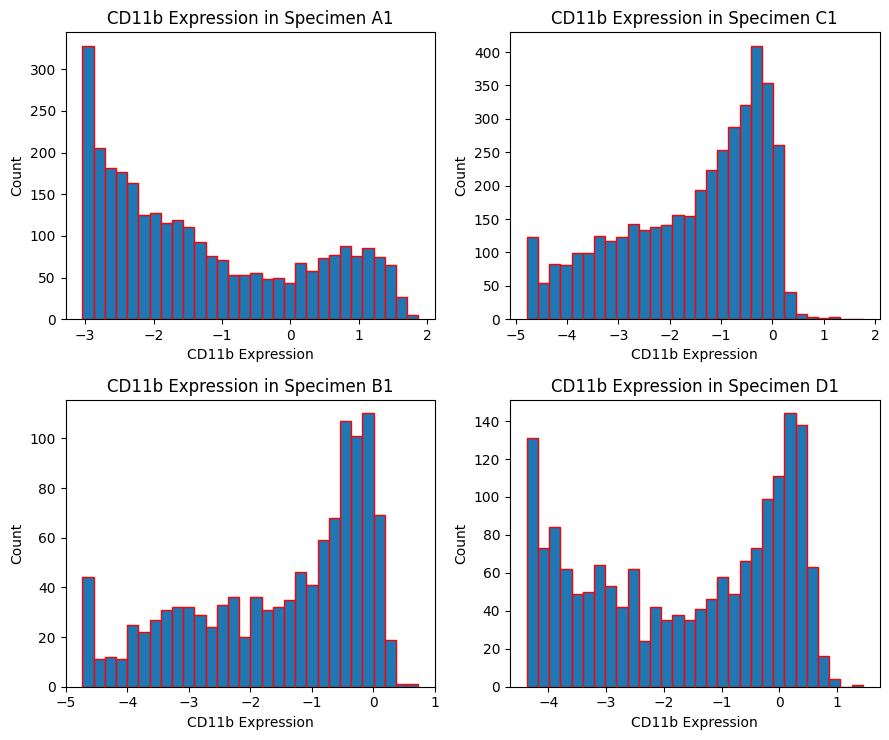

In [12]:
# Load the data
url = 'https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/protein_expression_data.csv'
df = pd.read_csv(url)

# Create a new column for specimen id extracted from 'VisSpot'
df['specimen_id'] = df.VisSpot.apply(lambda x: x.split('-')[2])

# List of unique specimens
specimens = df['specimen_id'].unique()

# Create a 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(9, 7.5))
axs = axs.flatten()  # Flatten the 2x2 array for easier iteration

# Plot the histogram for each specimen
for i, specimen in enumerate(specimens):
    data = df[df['specimen_id'] == specimen]['CD11b']
    axs[i].hist(data, bins=30, edgecolor='red')
    axs[i].set_title(f'CD11b Expression in Specimen {specimen}')
    axs[i].set_xlabel('CD11b Expression')
    axs[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

## iii. Image Pre-processing: Convert a selection of images from RGB to HED color space, focusing on the Hematoxylin channel (H) to highlight cellular nuclei. Provide visual examples following the hints in the notebook linked above. [2 marks]

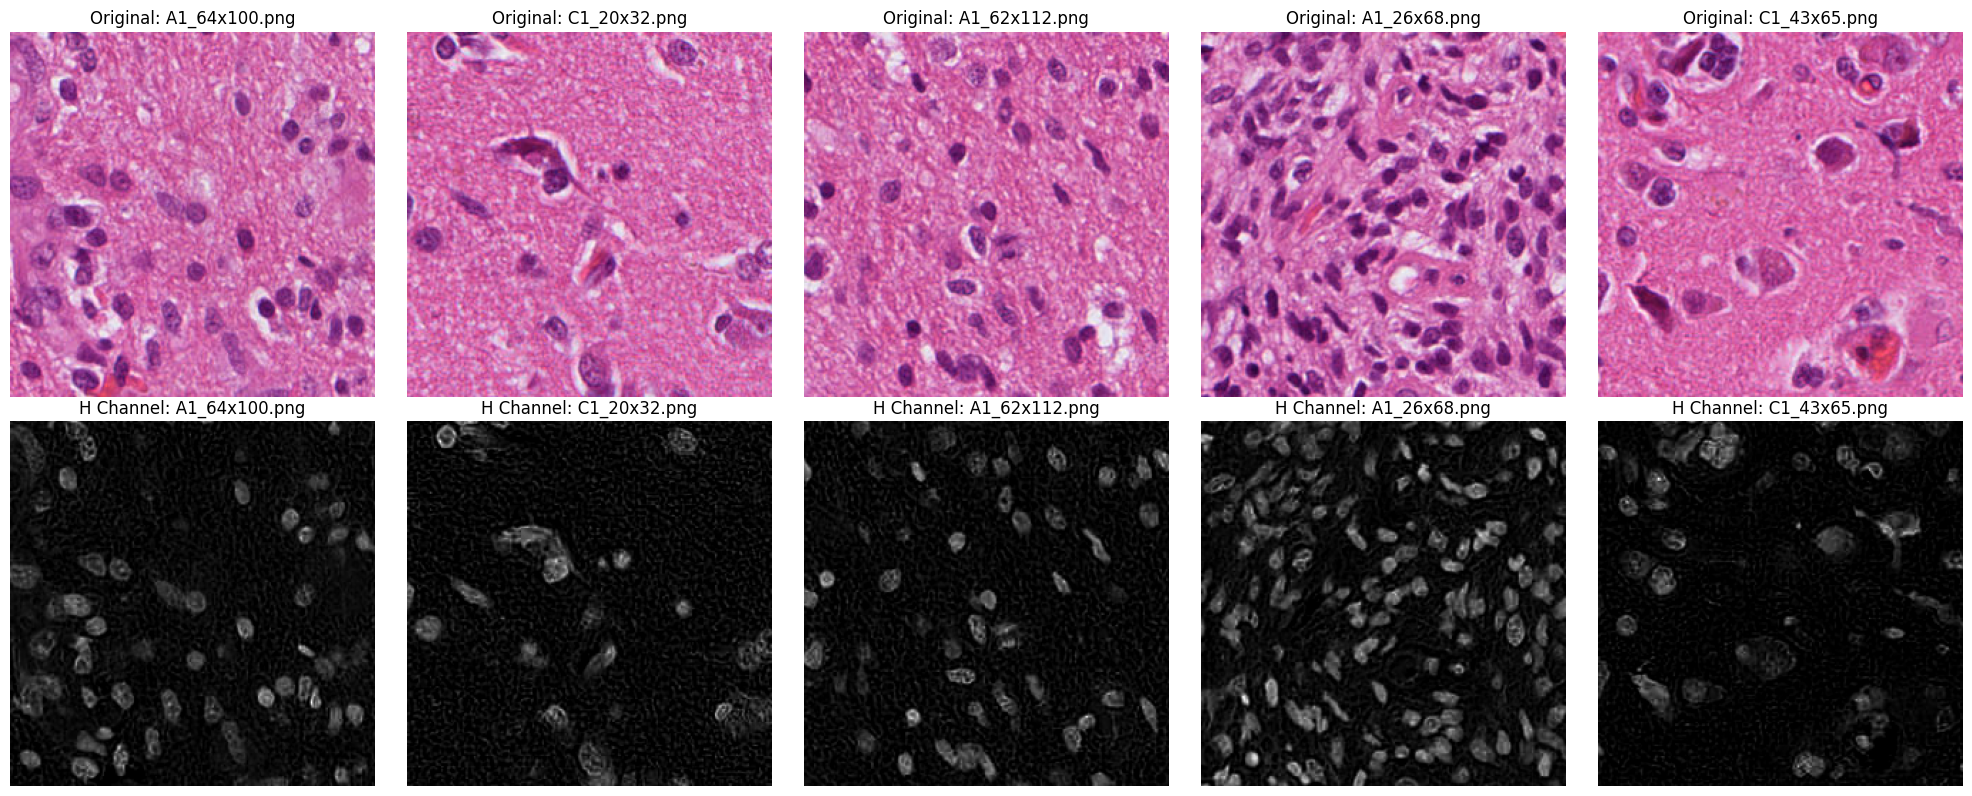

In [14]:
# Define the image folder path
image_folder = "C:\\Users\\abdul\\Documents\\CS909 Data mining\\assignment 2\\patches_256\\"

# List all PNG files in the folder
all_images = [f for f in os.listdir(image_folder) if f.endswith('.png')]

# Ensure there are at least 5 images available
if len(all_images) < 5:
    raise ValueError("Not enough images in the folder to select 5 at random.")

# Randomly select 5 images
selected_images = random.sample(all_images, 5)

# Create a 2x5 subplot grid: first row for original images, second row for H channel images
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows, 5 columns
axes = axes.flatten()  # flatten to iterate easily by index if needed

# Loop over each selected image
for i, image_file in enumerate(selected_images):
    # Build the full path to the image
    image_path = os.path.join(image_folder, image_file)
    
    # Read the image using skimage.io.imread
    I = imread(image_path)
    
    # If the image has an alpha channel, convert it to RGB
    if I.shape[-1] == 4:
        I = rgba2rgb(I)
    
    # Convert the image from RGB to HED color space
    I_hed = rgb2hed(I)
    # Extract the Hematoxylin (H) channel
    I_h = I_hed[:, :, 0]
    
    # Plot the original image in the first row (row 0)
    axes[i].imshow(I)
    axes[i].set_title(f'Original: {image_file}')
    axes[i].axis('off')
    
    # Plot the H channel in the corresponding subplot in the second row
    # Calculate index for second row: add 5 to the current index
    ax_h = axes[i + 5]
    ax_h.imshow(I_h, cmap='gray')
    ax_h.set_title(f'H Channel: {image_file}')
    ax_h.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## iv. Calculate the average intensity of the H-channel for each image. Create a scatter plot comparing these averages against the expression levels of CD11b for each image. Assess the correlation between H-channel intensity and CD11b expression. Discuss the potential of H-channel average as a predictive feature for CD11b expression. [3 marks]

### Discussion:

- Visually, there appears to be zero correlation between between H-channel Intensity and CD11b Expression
- This is statement is supported by the r value of -0.07, which clearly indicated no correlation
- Therefore the H-channel average is useless as a predictive feature for CD11b expression, since they are independant

Processing loop took 44.48 seconds


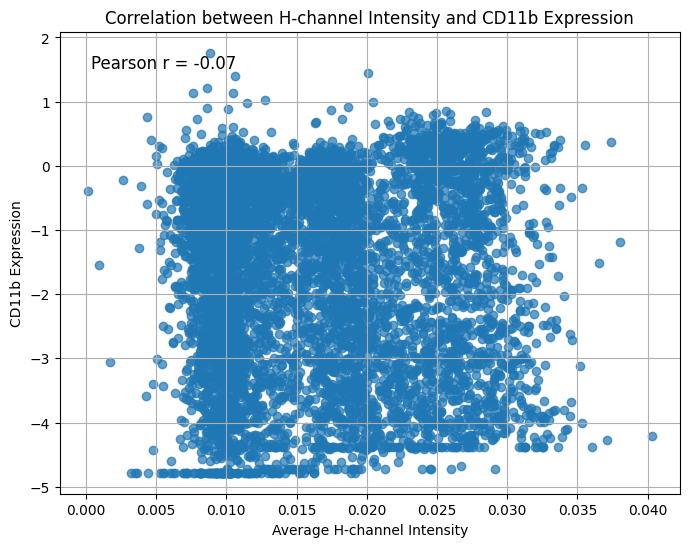

In [18]:
#importing df again
df = pd.read_csv('https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/protein_expression_data.csv')
df['specimen_id'] = df.VisSpot.apply(lambda x: x.split('-')[2])
df['image_id'] = df['specimen_id'] + '_' + df['id'].astype(str)
df = df.set_index('image_id').sort_index()

image_files = glob.glob(os.path.join(image_folder, "*.png"))

# Lists to store the average H-channel intensities and corresponding CD11b expression values
avg_H_intensities = []
cd11b_values = []

# Start timing the loop
start_time = time.time()

# Loop through each image file
for image_path in image_files:
    
    # Extract the image_id by removing the folder path and .png extension
    image_file = os.path.basename(image_path)
    image_id = os.path.splitext(image_file)[0]

    # Ensure the image_id exists in our DataFrame; if not, skip this image
    if image_id not in df.index:
        continue
    
    # Skip images from specimen A1
    if df.loc[image_id, 'specimen_id'] == 'A1':
        continue
    
    # Read the image using imread
    I = imread(image_path)
    # If the image has an alpha channel, convert it to RGB
    if I.shape[-1] == 4:
        I = rgba2rgb(I)
        
    # Convert the RGB image to HED color space and extract H-channel
    I_hed = rgb2hed(I)
    I_h = I_hed[:, :, 0]
    
    # Calculate the average intensity of the H-channel
    avg_intensity = np.mean(I_h)
    avg_H_intensities.append(avg_intensity)
    
    # Get the corresponding CD11b expression value from the DataFrame
    cd11b_val = df.loc[image_id, 'CD11b']
    cd11b_values.append(cd11b_val)

# End timing and print the duration of the loop
end_time = time.time()
print("Processing loop took {:.2f} seconds".format(end_time - start_time))

# Convert lists to numpy arrays (optional)
avg_H_intensities = np.array(avg_H_intensities)
cd11b_values = np.array(cd11b_values)

# Create a scatter plot comparing average H-channel intensity vs. CD11b expression
plt.figure(figsize=(8, 6))
plt.scatter(avg_H_intensities, cd11b_values, alpha=0.7)
plt.xlabel('Average H-channel Intensity')
plt.ylabel('CD11b Expression')
plt.title('Correlation between H-channel Intensity and CD11b Expression')
plt.grid(True)

# Calculate and display the Pearson correlation coefficient if data exists
corr_coef, p_value = pearsonr(avg_H_intensities, cd11b_values)
plt.text(0.05, 0.95, f'Pearson r = {corr_coef:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    
plt.show()

## iv. Calculate the average intensity of the blue channel for each image. Create a scatter plot comparing these averages against the expression levels of CD11b for each image. Assess the correlation between E-channel intensity and CD11b expression. Discuss the potential of E-channel average as a predictive feature for CD11b expression. [2 marks]

### Discussion: 

- Again, there appears to be no correlation between the average intensity of blue channel in an image, and the value of CD11b expression
- We calculate an r value of -0.06, further emphasising this point
- Therefore the blue channel average is useless as a predictive feature for CD11b expression, since they are independant

Processing loop took 26.00 seconds


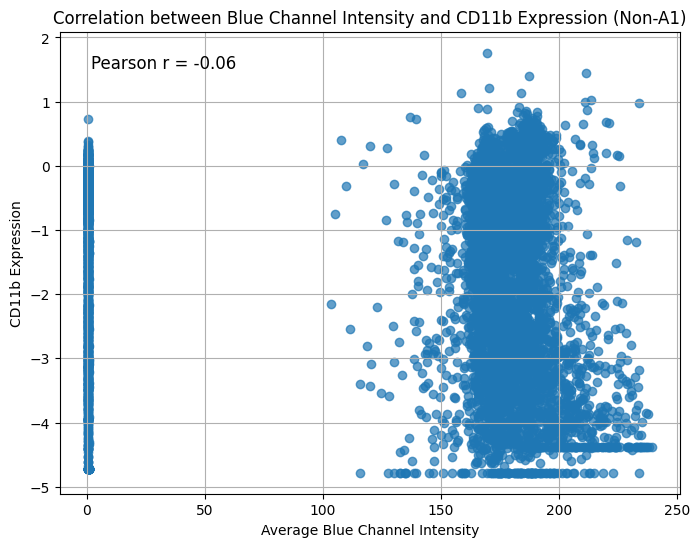

In [22]:
# Lists to store the average blue-channel intensities and corresponding CD11b expression values
blue_intensities = []
cd11b_values_filtered = []  # Ensure you have corresponding CD11b values for non-A1 images

# Start timing the loop
start_time = time.time()

# Loop through each image file
for image_path in image_files:
    # Extract the image_id by removing the folder path and the '.png' extension
    image_file = os.path.basename(image_path)
    image_id = os.path.splitext(image_file)[0]

    # Ensure the image_id exists in our DataFrame; if not, skip this image
    if image_id not in df.index:
        continue
    
    # Exclude images from specimen A1
    if df.loc[image_id, 'specimen_id'] == 'A1':
        continue
        
    # Read the image
    I = imread(image_path)
    # If the image has an alpha channel, convert it to RGB
    if I.shape[-1] == 4:
        I = rgba2rgb(I)
        
    # Extract the blue channel (index 2 of the RGB image)
    blue_channel = I[:, :, 2]
    
    # Calculate the average intensity of the blue channel
    avg_blue = np.mean(blue_channel)
    blue_intensities.append(avg_blue)
    
    # Also get the corresponding CD11b expression value for later plotting
    cd11b_values_filtered.append(df.loc[image_id, 'CD11b'])

# End timing and print the duration of the loop
end_time = time.time()
print("Processing loop took {:.2f} seconds".format(end_time - start_time))

# Convert lists to numpy arrays (optional)
blue_intensities = np.array(blue_intensities)
cd11b_values_filtered = np.array(cd11b_values_filtered)

# Create a scatter plot comparing average blue-channel intensity with CD11b expression
plt.figure(figsize=(8, 6))
plt.scatter(blue_intensities, cd11b_values_filtered, alpha=0.7)
plt.xlabel('Average Blue Channel Intensity')
plt.ylabel('CD11b Expression')
plt.title('Correlation between Blue Channel Intensity and CD11b Expression (Non-A1)')
plt.grid(True)

# Calculate and display the Pearson correlation coefficient
corr_coef, p_value = pearsonr(blue_intensities, cd11b_values_filtered)
plt.text(0.05, 0.95, f'Pearson r = {corr_coef:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.show()

# Discussion:
# The scatter plot illustrates the relationship between the average blue-channel intensity and the CD11b 
# expression levels for specimens excluding A1. The Pearson correlation coefficient quantifies the linear relationship.
# A high absolute value of Pearson r would suggest strong predictive power, while a low value indicates limited potential.


## v. Visualize (as a scatter plot) and quantify the degree of correlation or dependence between average H and average blue channel intensities across images. What are the implications of this?  [2 marks]

### Discussion:

- There does not seem to be much correlation between the two different quantities ( have an r value of -0.1)
- This implies that the two channels provide distinct information about the images

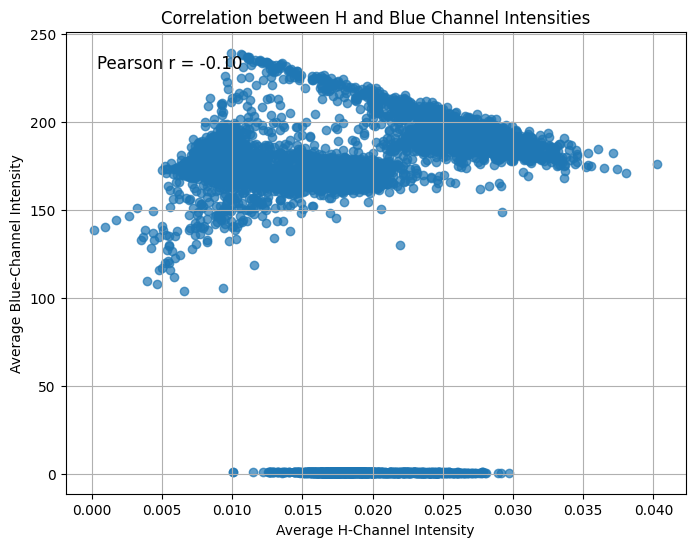

In [26]:
# Create a scatter plot with avg_H_intensities on the x-axis and blue_intensities on the y-axis
plt.figure(figsize=(8, 6))
plt.scatter(avg_H_intensities, blue_intensities, alpha=0.7)
plt.xlabel('Average H-Channel Intensity')
plt.ylabel('Average Blue-Channel Intensity')
plt.title('Correlation between H and Blue Channel Intensities')
plt.grid(True)

# Calculate the Pearson correlation coefficient between the two arrays
corr_coef, p_val = pearsonr(avg_H_intensities, blue_intensities)
plt.text(0.05, 0.95, f'Pearson r = {corr_coef:.2f}', transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top')

plt.show()


## vi. Is there association between protein expression levels of different proteins? If so, how can we quantify this association? [3 marks]

### Discussion:

- One way to quantify and easily visualize any associations is through a correlation matrix or heat map
- There does seem to be strong associations between certain protein expression levels, as we can see in the correlation matrix
- For example, TCIRG1 and MET have a correlation coefficient of 0.87, showing they have a strong positive correlation in expression

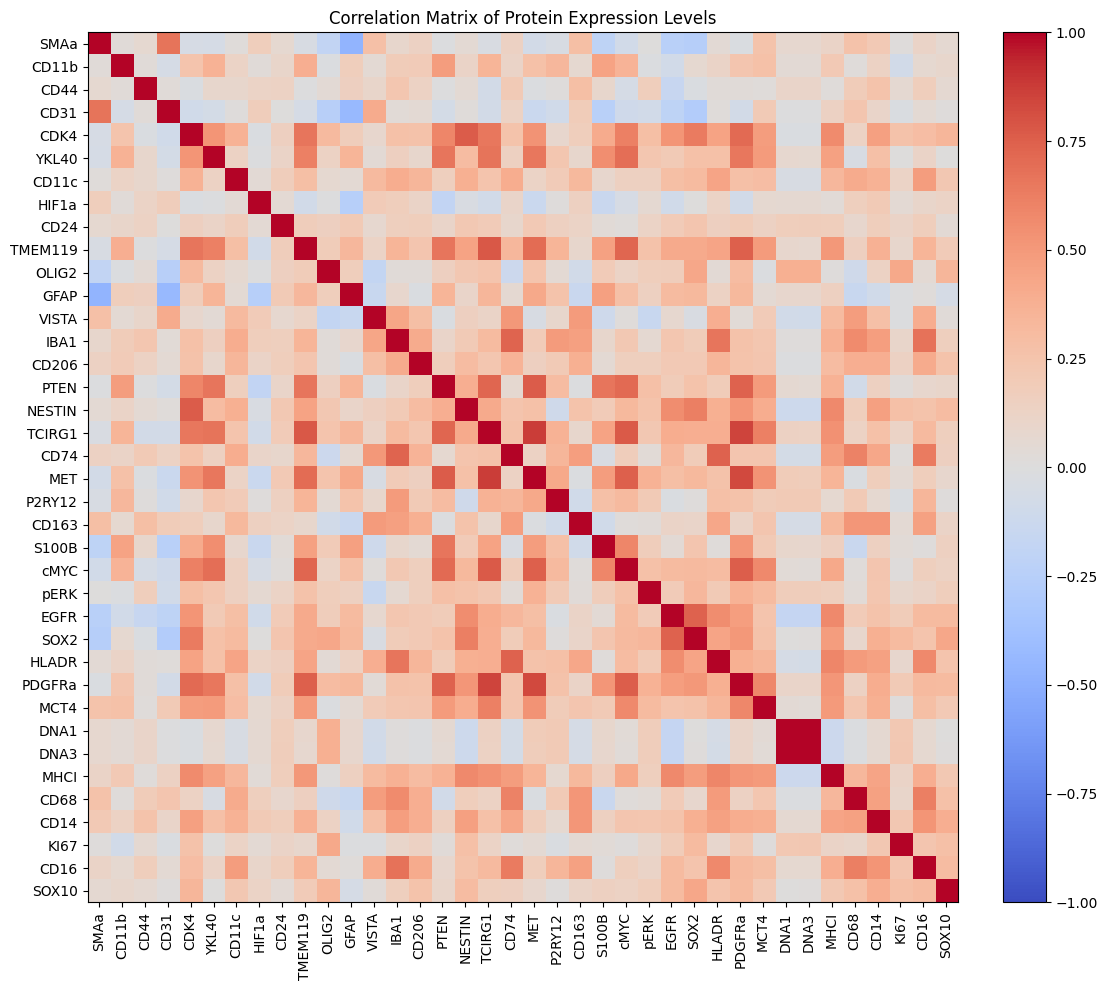

Highly correlated protein pairs (correlation > 0.8 or < -0.8):
TCIRG1 and MET: correlation = 0.87
TCIRG1 and PDGFRa: correlation = 0.85
MET and PDGFRa: correlation = 0.83
DNA1 and DNA3: correlation = 1.00


In [30]:
# Define the list of protein names (if not already defined)
protein_names = ['SMAa', 'CD11b', 'CD44', 'CD31', 'CDK4', 'YKL40', 'CD11c', 'HIF1a', 
                 'CD24', 'TMEM119', 'OLIG2', 'GFAP', 'VISTA', 'IBA1', 'CD206', 'PTEN', 
                 'NESTIN', 'TCIRG1', 'CD74', 'MET', 'P2RY12', 'CD163', 'S100B', 'cMYC', 
                 'pERK', 'EGFR', 'SOX2', 'HLADR', 'PDGFRa', 'MCT4', 'DNA1', 'DNA3', 
                 'MHCI', 'CD68', 'CD14', 'KI67', 'CD16', 'SOX10']

# Compute the correlation matrix for protein expression levels using Pearson's correlation
protein_corr = df[protein_names].corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
cax = plt.imshow(protein_corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Protein Expression Levels')
plt.xticks(ticks=np.arange(len(protein_names)), labels=protein_names, rotation=90)
plt.yticks(ticks=np.arange(len(protein_names)), labels=protein_names)
plt.colorbar(cax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# Print pairs of proteins with correlation > 0.8 or < -0.8
threshold = 0.8
print("Highly correlated protein pairs (correlation > 0.8 or < -0.8):")
for i in range(len(protein_names)):
    for j in range(i+1, len(protein_names)):
        corr_value = protein_corr.iloc[i, j]
        if corr_value > threshold or corr_value < -threshold:
            print(f"{protein_names[i]} and {protein_names[j]}: correlation = {corr_value:.2f}")


# Question No. 2: (Feature Extraction and Classical Regression) [30 Marks]

## i) Feature extraction [15 Marks]

### Features utilised:

- Basic statistical features (mean and variance) capture essential color and intensity distributions from both the RGB and HED representations
- 7 PCA features , which capture complex spatial patterns in a reduced-dimensional space.
- resized images to 64x64 to reduce computational load

In [35]:
# Initialize lists to store image identifiers, basic features, and data for PCA
image_ids = []
features_basic = []  # Basic statistics features: means and variances for RGB and HED channels
pca_input = []       # Flattened images (resized) for PCA
skipped = 0
A1_count = 0

start_time = time.time()
# Loop through each image file
for image_path in image_files:
    # Extract the image_id by removing the folder path and .png extension
    image_file = os.path.basename(image_path)
    image_id = os.path.splitext(image_file)[0]
    
    # Skip images not found in the CSV or from specimen A1 (testing set)
    if image_id not in df.index:
        skipped += 1
        continue

    if image_id.startswith("A1_"):
        A1_count += 1
        continue
    
    # Read the image
    I = imread(image_path)
    # Convert from RGBA to RGB if needed
    if I.ndim == 3 and I.shape[-1] == 4:
        I = rgba2rgb(I)
    
    # --- Basic Features from the Original RGB Image ---
    # Extract individual channels
    R_channel = I[:, :, 0]
    G_channel = I[:, :, 1]
    B_channel = I[:, :, 2]
    
    # Compute mean and variance for each RGB channel
    R_mean, R_var = np.mean(R_channel), np.var(R_channel)
    G_mean, G_var = np.mean(G_channel), np.var(G_channel)
    B_mean, B_var = np.mean(B_channel), np.var(B_channel)
    
    # --- Basic Features from the HED Image ---
    # Convert RGB image to HED color space
    I_hed = rgb2hed(I)
    # Extract the H, E, and D channels
    H_channel = I_hed[:, :, 0]
    E_channel = I_hed[:, :, 1]
    D_channel = I_hed[:, :, 2]
    
    # Compute mean and variance for each HED channel
    H_mean, H_var = np.mean(H_channel), np.var(H_channel)
    E_mean, E_var = np.mean(E_channel), np.var(E_channel)
    D_mean, D_var = np.mean(D_channel), np.var(D_channel)
    
    # Combine basic features into a single list (12 features total)
    basic_features = [R_mean, R_var, G_mean, G_var, B_mean, B_var,
                      H_mean, H_var, E_mean, E_var, D_mean, D_var]
    
    # Append the image_id and basic features
    image_ids.append(image_id)
    features_basic.append(basic_features)
    
    # --- PCA Features ---
    # Resize the image to reduce dimensionality
    I_resized = resize(I, (64, 64), anti_aliasing=True)
    # Flatten the resized image (using all three RGB channels)
    pca_input.append(I_resized.flatten())

end_time = time.time()
print("Processing loop took {:.2f} seconds".format(end_time - start_time))

# Convert the lists to numpy arrays for further processing
features_basic = np.array(features_basic)
pca_input = np.array(pca_input)

# Apply randomized PCA to the flattened, resized images to extract additional features
# We choose 25 principal components with randomized SVD
n_components = 7
pca_model = PCA(n_components=n_components, svd_solver='randomized', random_state=21)
pca_features = pca_model.fit_transform(pca_input)

# Create a DataFrame for the basic features with descriptive column names
columns_basic = ['R_mean', 'R_var', 'G_mean', 'G_var', 'B_mean', 'B_var',
                 'H_mean', 'H_var', 'E_mean', 'E_var', 'D_mean', 'D_var']
df_basic = pd.DataFrame(features_basic, index=image_ids, columns=columns_basic)

# Create a DataFrame for the PCA features
columns_pca = [f'pca_{i+1}' for i in range(n_components)]
df_pca = pd.DataFrame(pca_features, index=image_ids, columns=columns_pca)

# Combine both sets of features into a single DataFrame
df_features = pd.concat([df_basic, df_pca], axis=1)

# Extract the target variable (CD11b) from the CSV DataFrame (for training images only)
df_target = df[df['specimen_id'] != 'A1'][['CD11b']]

# Merge the features with the target variable based on image_id (which is the index)
df_features = df_features.join(df_target, how='inner')

print("No. images skipped: ", skipped)
print("No. images of specimen A1: ", A1_count)
# Display the first few rows of the feature DataFrame
print("Extracted features for regression (excluding testing specimen A1):")
print(df_features.head())


Processing loop took 99.72 seconds
No. images skipped:  2235
No. images of specimen A1:  2894
Extracted features for regression (excluding testing specimen A1):
            R_mean     R_var    G_mean     G_var    B_mean     B_var  \
B1_24x60  0.789487  0.020471  0.528272  0.044989  0.731652  0.019906   
B1_25x59  0.827528  0.014900  0.630595  0.050397  0.789530  0.019560   
B1_26x52  0.906469  0.000733  0.901311  0.002442  0.936298  0.001222   
B1_26x54  0.905069  0.000914  0.896223  0.004352  0.933364  0.001682   
B1_26x58  0.807493  0.015583  0.567812  0.038208  0.757502  0.016084   

            H_mean     H_var    E_mean     E_var    D_mean     D_var  \
B1_24x60  0.017473  0.000503  0.030747  0.000475  0.020317  0.000154   
B1_25x59  0.014374  0.000320  0.021589  0.000429  0.015468  0.000161   
B1_26x52  0.010026  0.000014  0.000385  0.000020  0.002605  0.000012   
B1_26x54  0.010063  0.000013  0.000722  0.000024  0.002855  0.000014   
B1_26x58  0.015696  0.000352  0.026035  0.0003

## ii) Classical Regression [15 Marks]

### Justification for Using RMSE as the Most Appropriate Metric:
- **Intuitive Interpretation:** RMSE is measured in the same units as the target variable (protein expression), making it easy to interpret the magnitude of errors.s.
- **Sensitivity to Large Errors:** By squaring the errors, RMSE penalizes larger mistakes more severely, which is critical when large deviations can impact biological interpretations.
- **Standard and Comparable:** RMSE is a widely accepted metric in regression tasks, facilitating clear comparisons between models and studies.


In [38]:
# ----------------------------
# Prepare Test Data Features (Specimen A1)
# ----------------------------

# Initialize lists for test features
image_ids_test = []
features_basic_test = []
pca_input_test = []

for image_path in image_files:
    image_file = os.path.basename(image_path)
    image_id = os.path.splitext(image_file)[0]
    
    # Use only images present in df and from specimen A1 (test)
    if image_id not in df.index:
        continue
    if df.loc[image_id, 'specimen_id'] != 'A1':
        continue
    
    # Read and preprocess the image
    I = imread(image_path)
    if I.ndim == 3 and I.shape[-1] == 4:
        I = rgba2rgb(I)
    
    # --- Basic Features from Original RGB ---
    R_channel = I[:, :, 0]
    G_channel = I[:, :, 1]
    B_channel = I[:, :, 2]
    R_mean, R_var = np.mean(R_channel), np.var(R_channel)
    G_mean, G_var = np.mean(G_channel), np.var(G_channel)
    B_mean, B_var = np.mean(B_channel), np.var(B_channel)
    
    # --- Basic Features from HED ---
    I_hed = rgb2hed(I)
    H_channel = I_hed[:, :, 0]
    E_channel = I_hed[:, :, 1]
    D_channel = I_hed[:, :, 2]
    H_mean, H_var = np.mean(H_channel), np.var(H_channel)
    E_mean, E_var = np.mean(E_channel), np.var(E_channel)
    D_mean, D_var = np.mean(D_channel), np.var(D_channel)
    
    basic_features = [R_mean, R_var, G_mean, G_var, B_mean, B_var,
                      H_mean, H_var, E_mean, E_var, D_mean, D_var]
    
    image_ids_test.append(image_id)
    features_basic_test.append(basic_features)
    
    # --- PCA Input (resize and flatten) ---
    I_resized = resize(I, (64, 64), anti_aliasing=True)
    pca_input_test.append(I_resized.flatten())

features_basic_test = np.array(features_basic_test)
pca_input_test = np.array(pca_input_test)

# Use the same PCA transformation learned on the training data
pca_features_test = pca_model.transform(pca_input_test)

# Build test features DataFrames
columns_basic = ['R_mean', 'R_var', 'G_mean', 'G_var', 'B_mean', 'B_var',
                 'H_mean', 'H_var', 'E_mean', 'E_var', 'D_mean', 'D_var']
df_basic_test = pd.DataFrame(features_basic_test, index=image_ids_test, columns=columns_basic)
columns_pca = [f'pca_{i+1}' for i in range(n_components)]
df_pca_test = pd.DataFrame(pca_features_test, index=image_ids_test, columns=columns_pca)
df_features_test = pd.concat([df_basic_test, df_pca_test], axis=1)

# Add target variable (CD11b) for test images
df_target_test = df[df['specimen_id'] == 'A1'][['CD11b']]
df_features_test = df_features_test.join(df_target_test, how='inner')


Training OLS Regression Model...
OLS Regression Training Time: 0.01 seconds
OLS Regression Performance:
RMSE: 1.5821
Pearson Correlation: 0.4522
Spearman Correlation: 0.5178
R2 Score: -0.2136


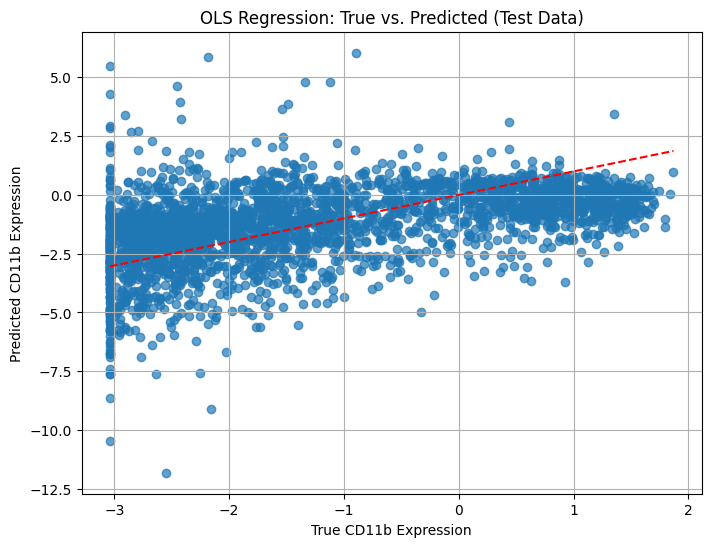

In [39]:
# ----------------------------
# Prepare Training Data
# ----------------------------
# Split into X (features) and y (target)
X_train = df_features.drop(columns=['CD11b']).values
y_train = df_features['CD11b'].values

X_test = df_features_test.drop(columns=['CD11b']).values
y_test = df_features_test['CD11b'].values

# ----------------------------
# Define a function to compute performance metrics
# ----------------------------
def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    pearson_corr, _ = pearsonr(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, pearson_corr, spearman_corr, r2

# ----------------------------
# Model 1: Ordinary Least Squares (OLS) Regression
# ----------------------------
print("Training OLS Regression Model...")
start_time = time.time()

ols_model = LinearRegression()
ols_model.fit(X_train, y_train)
ols_train_time = time.time() - start_time

# Predict on test data
y_pred_ols = ols_model.predict(X_test)
rmse_ols, pearson_ols, spearman_ols, r2_ols = compute_metrics(y_test, y_pred_ols)

print(f"OLS Regression Training Time: {ols_train_time:.2f} seconds")
print("OLS Regression Performance:")
print(f"RMSE: {rmse_ols:.4f}")
print(f"Pearson Correlation: {pearson_ols:.4f}")
print(f"Spearman Correlation: {spearman_ols:.4f}")
print(f"R2 Score: {r2_ols:.4f}")

# Scatter plot for OLS predictions vs. true values
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_ols, alpha=0.7)
plt.xlabel("True CD11b Expression")
plt.ylabel("Predicted CD11b Expression")
plt.title("OLS Regression: True vs. Predicted (Test Data)")
plt.grid(True)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # reference line y=x
plt.show()


Training Random Forest Regression Model with Randomized Grid Search...
Random Forest Grid Search Training Time: 294.72 seconds
Best Parameters from Randomized Grid Search:
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10}
Random Forest Regression Performance:
RMSE: 1.2902
Pearson Correlation: 0.5533
Spearman Correlation: 0.5582
R2 Score: 0.1930


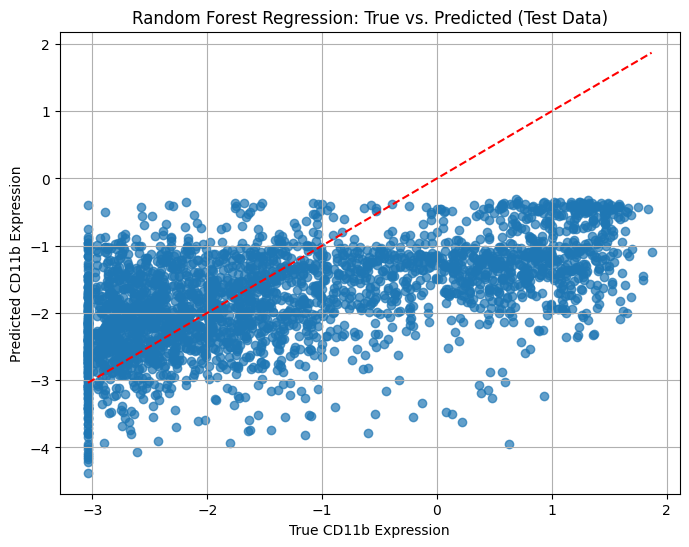

In [40]:
# ----------------------------
# Model 2: Random Forest Regression with Randomized Grid Search
# ----------------------------
print("Training Random Forest Regression Model with Randomized Grid Search...")
param_dist = {
    'n_estimators': [50, 100, 200, 300,400],
    'max_depth': [None, 10, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4,8]
}

rf = RandomForestRegressor(random_state=21)

# 4-fold cross validation with 25 iterations
start_time = time.time()
rf_random_search = RandomizedSearchCV(estimator=rf,
                                        param_distributions=param_dist,
                                        n_iter=25,
                                        cv=4,
                                        random_state=21,
                                        n_jobs=-1,
                                        scoring="neg_mean_squared_error")
rf_random_search.fit(X_train, y_train)
rf_train_time = time.time() - start_time

print(f"Random Forest Grid Search Training Time: {rf_train_time:.2f} seconds")
print("Best Parameters from Randomized Grid Search:")
print(rf_random_search.best_params_)

# Use the best estimator for predictions
rf_best = rf_random_search.best_estimator_
y_pred_rf = rf_best.predict(X_test)
rmse_rf, pearson_rf, spearman_rf, r2_rf = compute_metrics(y_test, y_pred_rf)

print("Random Forest Regression Performance:")
print(f"RMSE: {rmse_rf:.4f}")
print(f"Pearson Correlation: {pearson_rf:.4f}")
print(f"Spearman Correlation: {spearman_rf:.4f}")
print(f"R2 Score: {r2_rf:.4f}")

# Scatter plot for Random Forest predictions vs. true values
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, alpha=0.7)
plt.xlabel("True CD11b Expression")
plt.ylabel("Predicted CD11b Expression")
plt.title("Random Forest Regression: True vs. Predicted (Test Data)")
plt.grid(True)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # reference line y=x
plt.show()

# Question No. 3 (Using Neural Networks) [55  Marks]

## (i) [20 Marks]

### Architectural Design:

- **MLP with 4 hidden layers:** 256 → 128 → 64 → 3→ 16 → 1 (output)
- **Input:** 22 extracted features (basic statistics + PCA components)
- **Hierarchical feature extraction:** Captures complex, non-linear relationships in data
- **Optimized for speed:** Much faster to train than CNNs or transfer learning
- **Efficient single-output regression:** Predicts CD11b expression with minimal computational overhead


In [121]:
# Ensure matplotlib plots appear inline
%matplotlib inline

# ----------------------------
# Load CSV Data and Process IDs
csv_url = 'https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/protein_expression_data.csv'
df = pd.read_csv(csv_url)
df['specimen_id'] = df.VisSpot.apply(lambda x: x.split('-')[2])
df['image_id'] = df['specimen_id'] + '_' + df['id'].astype(str)
df = df.set_index('image_id').sort_index()

image_folder = r"C:\Users\abdul\Documents\CS909 Data mining\assignment 2\patches_256"


In [152]:
# Cell 2: Feature Extraction & PCA
# We extract:
# - 12 basic features: mean and variance for each channel (R, G, B and H, E, D)
# - PCA features: from a resized (32x32) version of the image (10 components)
# We'll split images into training (specimens B1, C1, D1) and test (specimen A1)

train_ids = []
basic_train = []
pca_train_input = []

test_ids = []
basic_test = []
pca_test_input = []

# List all PNG images in the folder
image_files = glob.glob(os.path.join(image_folder, "*.png"))

for image_path in image_files:
    image_file = os.path.basename(image_path)
    image_id = os.path.splitext(image_file)[0]
    
    # Skip images not in CSV
    if image_id not in df.index:
        continue
    
    specimen = df.loc[image_id, 'specimen_id']
    
    # Read image
    I = imread(image_path)
    if I.ndim == 3 and I.shape[-1] == 4:
        I = rgba2rgb(I)
    
    # --- Basic features from RGB ---
    R = I[:, :, 0]
    G = I[:, :, 1]
    B = I[:, :, 2]
    R_mean, R_var = np.mean(R), np.var(R)
    G_mean, G_var = np.mean(G), np.var(G)
    B_mean, B_var = np.mean(B), np.var(B)
    
    # --- Basic features from HED ---
    I_hed = rgb2hed(I)
    H = I_hed[:, :, 0]
    E = I_hed[:, :, 1]
    D = I_hed[:, :, 2]
    H_mean, H_var = np.mean(H), np.var(H)
    E_mean, E_var = np.mean(E), np.var(E)
    D_mean, D_var = np.mean(D), np.var(D)
    
    basic_feats = [R_mean, R_var, G_mean, G_var, B_mean, B_var,
                   H_mean, H_var, E_mean, E_var, D_mean, D_var]
    
    # --- PCA input: resize image to 64x64 and flatten ---
    I_resized = resize(I, (64, 64), anti_aliasing=True)
    flat_img = I_resized.flatten()
    
    # Split based on specimen: A1 for test, others for training
    if specimen == 'A1':
        test_ids.append(image_id)
        basic_test.append(basic_feats)
        pca_test_input.append(flat_img)
    else:
        train_ids.append(image_id)
        basic_train.append(basic_feats)
        pca_train_input.append(flat_img)

# Convert lists to numpy arrays
basic_train = np.array(basic_train)
pca_train_input = np.array(pca_train_input)
basic_test = np.array(basic_test)
pca_test_input = np.array(pca_test_input)

# ----------------------------
# Apply PCA on Training Data, then Transform Test Data
n_components = 20
pca_model = PCA(n_components=n_components, svd_solver='randomized', random_state=42)
pca_train_features = pca_model.fit_transform(pca_train_input)
pca_test_features = pca_model.transform(pca_test_input)

# Combine basic features (12) and PCA features (20) => Total 32 features
X_train = np.hstack([basic_train, pca_train_features])
X_test = np.hstack([basic_test, pca_test_features])

# Get target values (CD11b) using image ids
y_train = df.loc[train_ids, 'CD11b'].values
y_test = df.loc[test_ids, 'CD11b'].values

print("Feature extraction complete:")
print(f"Training samples: {X_train.shape[0]}, Feature dimension: {X_train.shape[1]}")
print(f"Test samples: {X_test.shape[0]}, Feature dimension: {X_test.shape[1]}")


Feature extraction complete:
Training samples: 7027, Feature dimension: 32
Test samples: 2894, Feature dimension: 32


In [153]:
%load_ext tensorboard
%tensorboard --logdir=runs/feature_nn_experiment

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 6784), started 6:48:52 ago. (Use '!kill 6784' to kill it.)

In [154]:
# Cell 3: Create PyTorch Datasets & Dataloaders

# Convert training and test data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create training dataset and dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print("PyTorch datasets created.")


PyTorch datasets created.


In [155]:
# Cell 4: Define the Updated Neural Network Model with Additional Layers

class FeatureNN(nn.Module):
    def __init__(self, input_dim):
        super(FeatureNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),  # Additional hidden layer
            nn.ReLU(),
            nn.Linear(16, 1)   # Output layer
        )
    def forward(self, x):
        return self.net(x)


input_dim = X_train.shape[1]  # 22 features
model = FeatureNN(input_dim)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Updated model defined. Running on device:", device)


Updated model defined. Running on device: cpu


In [156]:
# Cell 5: Setup TensorBoard SummaryWriter

# Create a SummaryWriter to log training metrics
writer = SummaryWriter(log_dir="runs/feature_nn_experiment")
print("TensorBoard SummaryWriter created. Check logs in 'runs/feature_nn_experiment'.")


TensorBoard SummaryWriter created. Check logs in 'runs/feature_nn_experiment'.


In [157]:
# Cell 6: Updated Training Loop with TensorBoard Logging and Timing

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 75
train_losses = []

print("Starting training...")
start_training = time.time()

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_start = time.time()
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * batch_X.size(0)
    
    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Log training loss to TensorBoard
    writer.add_scalar("Loss/train", epoch_loss, epoch)
    
    epoch_duration = time.time() - epoch_start
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}, Time: {epoch_duration:.2f} sec")
    
total_training_time = time.time() - start_training
print(f"Total training time: {total_training_time:.2f} seconds")

writer.close()


Starting training...
Epoch 1/75, Loss: 2.3289, Time: 0.91 sec
Epoch 2/75, Loss: 1.9617, Time: 1.06 sec
Epoch 3/75, Loss: 1.7110, Time: 1.15 sec
Epoch 4/75, Loss: 1.6807, Time: 1.05 sec
Epoch 5/75, Loss: 1.6518, Time: 0.80 sec
Epoch 6/75, Loss: 1.6000, Time: 0.99 sec
Epoch 7/75, Loss: 1.6203, Time: 0.91 sec
Epoch 8/75, Loss: 1.5712, Time: 0.70 sec
Epoch 9/75, Loss: 1.5255, Time: 0.64 sec
Epoch 10/75, Loss: 1.4955, Time: 0.78 sec
Epoch 11/75, Loss: 1.5057, Time: 1.02 sec
Epoch 12/75, Loss: 1.4767, Time: 0.98 sec
Epoch 13/75, Loss: 1.4660, Time: 0.83 sec
Epoch 14/75, Loss: 1.4528, Time: 0.92 sec
Epoch 15/75, Loss: 1.4367, Time: 1.08 sec
Epoch 16/75, Loss: 1.4333, Time: 1.07 sec
Epoch 17/75, Loss: 1.4306, Time: 0.72 sec
Epoch 18/75, Loss: 1.4084, Time: 0.77 sec
Epoch 19/75, Loss: 1.4258, Time: 1.18 sec
Epoch 20/75, Loss: 1.4200, Time: 1.56 sec
Epoch 21/75, Loss: 1.3789, Time: 0.83 sec
Epoch 22/75, Loss: 1.3737, Time: 0.90 sec
Epoch 23/75, Loss: 1.3650, Time: 0.88 sec
Epoch 24/75, Loss: 1.3

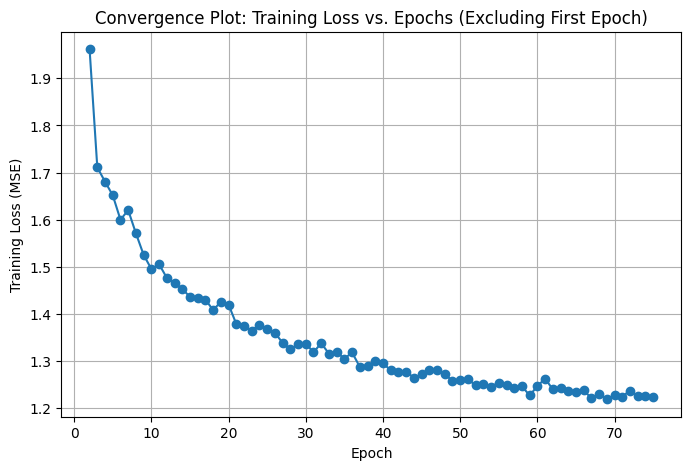

In [158]:
# Cell 7: Plot Convergence - Excluding the First Epoch

plt.figure(figsize=(8, 5))
plt.plot(range(2, n_epochs+1), train_losses[1:], marker='o')  # Exclude first epoch
plt.xlabel('Epoch')
plt.ylabel('Training Loss (MSE)')
plt.title('Convergence Plot: Training Loss vs. Epochs (Excluding First Epoch)')
plt.grid(True)
plt.show()


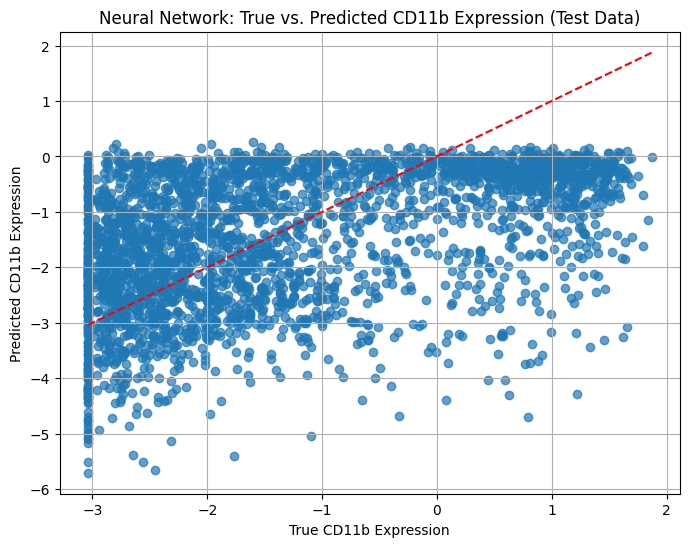

Neural Network Performance on Test Data:
RMSE: 1.4105
Pearson Correlation: 0.4473
Spearman Correlation: 0.4620
R2 Score: 0.0355


In [159]:
# Cell 8: Evaluate on Test Data & Compute Metrics
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor.to(device))
    y_pred = y_pred_tensor.cpu().numpy().flatten()
    y_true = y_test_tensor.cpu().numpy().flatten()

# Scatter plot: True vs. Predicted CD11b Expression
plt.figure(figsize=(8,6))
plt.scatter(y_true, y_pred, alpha=0.7)
plt.xlabel("True CD11b Expression")
plt.ylabel("Predicted CD11b Expression")
plt.title("Neural Network: True vs. Predicted CD11b Expression (Test Data)")
plt.grid(True)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')  # reference line
plt.show()

# Compute performance metrics
rmse_nn = np.sqrt(mean_squared_error(y_true, y_pred))
pearson_nn, _ = pearsonr(y_true, y_pred)
spearman_nn, _ = spearmanr(y_true, y_pred)
r2_nn = r2_score(y_true, y_pred)

print("Neural Network Performance on Test Data:")
print(f"RMSE: {rmse_nn:.4f}")
print(f"Pearson Correlation: {pearson_nn:.4f}")
print(f"Spearman Correlation: {spearman_nn:.4f}")
print(f"R2 Score: {r2_nn:.4f}")


# Question No. 3 (Using Neural Networks) [55  Marks]

## (ii) [20 Marks] 

### Architectural Design:

- **MLP with 4 hidden layers:** 256 → 128 → 64 → 32 → 38 (output)
- **Input:** 22 extracted features (basic statistics + PCA components)
- **Efficient multi-output regression:** Predicts all 38 protein expressions simultaneously
- **Hierarchical feature learning:** Captures shared and individual protein expression patterns
- **Faster than CNNs/transfer learning:** Lightweight, optimized for quick training


In [160]:
# Cell 1: Setup

# For inline plotting (if using Jupyter)
%matplotlib inline

# Load CSV data and create specimen and image IDs
csv_url = 'https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/protein_expression_data.csv'
df = pd.read_csv(csv_url)
df['specimen_id'] = df.VisSpot.apply(lambda x: x.split('-')[2])
df['image_id'] = df['specimen_id'] + '_' + df['id'].astype(str)
df = df.set_index('image_id').sort_index()

# List of all 38 protein targets
protein_names = ['SMAa', 'CD11b', 'CD44', 'CD31', 'CDK4', 'YKL40', 'CD11c', 'HIF1a', 
                 'CD24', 'TMEM119', 'OLIG2', 'GFAP', 'VISTA', 'IBA1', 'CD206', 'PTEN', 
                 'NESTIN', 'TCIRG1', 'CD74', 'MET', 'P2RY12', 'CD163', 'S100B', 'cMYC', 
                 'pERK', 'EGFR', 'SOX2', 'HLADR', 'PDGFRa', 'MCT4', 'DNA1', 'DNA3', 
                 'MHCI', 'CD68', 'CD14', 'KI67', 'CD16', 'SOX10']


image_folder = r"C:\Users\abdul\Documents\CS909 Data mining\assignment 2\patches_256"


In [161]:
# Cell 2: Feature Extraction for All Images (for multi-output regression)
# For each image, we extract:
#   - 12 basic features (mean & variance for R, G, B, and H, E, D channels)
#   - PCA features (10 components from a resized 32x32 version of the image)
# We also extract the target vector (all 38 proteins) and record the specimen id (for grouping)

# Containers for features, targets, and groups
all_ids = []
basic_features_list = []
pca_input_list = []
groups = []  # specimen ids
targets_list = []  # multi-output targets for 38 proteins

# Get all PNG image files in the folder
image_files = glob.glob(os.path.join(image_folder, "*.png"))

for image_path in image_files:
    image_file = os.path.basename(image_path)
    image_id = os.path.splitext(image_file)[0]
    
    # Skip images not in the CSV
    if image_id not in df.index:
        continue
    
    # Get specimen id (group) and target values for all proteins
    specimen = df.loc[image_id, 'specimen_id']
    # Ensure target is a vector of shape (38,)
    targets = df.loc[image_id, protein_names].values.astype(np.float32)
    
    # Read image
    I = imread(image_path)
    if I.ndim == 3 and I.shape[-1] == 4:
        I = rgba2rgb(I)
    
    # --- Basic Features from RGB channels ---
    R = I[:, :, 0]
    G = I[:, :, 1]
    B = I[:, :, 2]
    R_mean, R_var = np.mean(R), np.var(R)
    G_mean, G_var = np.mean(G), np.var(G)
    B_mean, B_var = np.mean(B), np.var(B)
    
    # --- Basic Features from HED channels ---
    I_hed = rgb2hed(I)
    H = I_hed[:, :, 0]
    E = I_hed[:, :, 1]
    D = I_hed[:, :, 2]
    H_mean, H_var = np.mean(H), np.var(H)
    E_mean, E_var = np.mean(E), np.var(E)
    D_mean, D_var = np.mean(D), np.var(D)
    
    basic_feats = [R_mean, R_var, G_mean, G_var, B_mean, B_var,
                   H_mean, H_var, E_mean, E_var, D_mean, D_var]
    
    # --- PCA input: resize to 64x64 and flatten ---
    I_resized = resize(I, (64, 64), anti_aliasing=True)
    flat_img = I_resized.flatten()
    
    # Append all data
    all_ids.append(image_id)
    basic_features_list.append(basic_feats)
    pca_input_list.append(flat_img)
    groups.append(specimen)
    targets_list.append(targets)

# Convert lists to numpy arrays
basic_features = np.array(basic_features_list)       # shape: (n_samples, 12)
pca_input = np.array(pca_input_list)                  # shape: (n_samples, 64*64*3)
groups = np.array(groups)                             # shape: (n_samples,)
targets_all = np.array(targets_list)                  # shape: (n_samples, 38)

# Apply PCA on the flattened images (fit on all data for simplicity; in practice, one might fit only on training)
n_components = 20
pca_model = PCA(n_components=n_components, svd_solver='randomized', random_state=21)
pca_features = pca_model.fit_transform(pca_input)      # shape: (n_samples, 20)

# Combine basic features and PCA features => Total feature dimension = 12 + 20 = 32
X_all = np.hstack([basic_features, pca_features])

print("Feature extraction complete:")
print(f"Total samples: {X_all.shape[0]}, Feature dimension: {X_all.shape[1]}")
print(f"Target shape: {targets_all.shape}")


Feature extraction complete:
Total samples: 9921, Feature dimension: 32
Target shape: (9921, 38)


In [162]:
# Cell 3: Prepare PyTorch Dataset (for multi-output regression)

# Convert features and targets to torch tensors
X_tensor = torch.tensor(X_all, dtype=torch.float32)
y_tensor = torch.tensor(targets_all, dtype=torch.float32)  # shape: (n_samples, 38)

# We'll use the groups array (specimen IDs) for GroupKFold cross-validation.


In [163]:
# Cell 4: Define the Multi-Output Neural Network Model
# The model predicts 38 protein expression values from 22 input features.

class MultiOutputNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MultiOutputNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, output_dim)  # Output layer: one value per protein
        )
        
    def forward(self, x):
        return self.net(x)

input_dim = X_all.shape[1]  # 32 features
output_dim = len(protein_names)  # 38 proteins


In [164]:
# Cell 5: Leave-One-Specimen-Out Cross-Validation using GroupKFold

# Set training hyperparameters
n_epochs = 75
batch_size = 32
learning_rate = 0.001

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# To store metrics for each fold and each protein, we create a dictionary.
# For each metric, we store an array of shape (n_folds, n_proteins)
n_folds = 4  # since we have 4 specimens
rmse_all = []
pearson_all = []
spearman_all = []
r2_all = []

# Create GroupKFold object; groups are the specimen IDs (e.g., "A1", "B1", etc.)
gkf = GroupKFold(n_splits=n_folds)
groups_numeric = np.arange(len(groups))  # not used; we use groups as strings directly in GroupKFold

fold_idx = 1
for train_idx, test_idx in gkf.split(X_all, targets_all, groups):
    print(f"\n=== Fold {fold_idx} (Test group specimens: {np.unique(groups[test_idx])}) ===")
    
    # Prepare training and test sets for this fold
    X_train_fold = torch.tensor(X_all[train_idx], dtype=torch.float32).to(device)
    y_train_fold = torch.tensor(targets_all[train_idx], dtype=torch.float32).to(device)
    X_test_fold = torch.tensor(X_all[test_idx], dtype=torch.float32).to(device)
    y_test_fold = torch.tensor(targets_all[test_idx], dtype=torch.float32).to(device)
    
    # Create DataLoader for training
    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model (new instance for each fold) and move to device
    model_cv = MultiOutputNN(input_dim, output_dim).to(device)
    optimizer = optim.Adam(model_cv.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    # Optionally, create a SummaryWriter for TensorBoard logging for this fold
    writer = SummaryWriter(log_dir=f"runs/multi_output_fold_{fold_idx}")
    
    # Training loop for this fold
    fold_train_losses = []
    fold_start_time = time.time()
    for epoch in range(n_epochs):
        model_cv.train()
        epoch_loss = 0.0
        epoch_start = time.time()
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model_cv(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_X.size(0)
        
        epoch_loss /= len(train_loader.dataset)
        fold_train_losses.append(epoch_loss)
        writer.add_scalar("Loss/train", epoch_loss, epoch)
        print(f"Fold {fold_idx} Epoch {epoch+1}/{n_epochs}: Loss = {epoch_loss:.4f}, Time = {time.time()-epoch_start:.2f}s")
    
    total_fold_time = time.time() - fold_start_time
    print(f"Fold {fold_idx} training complete in {total_fold_time:.2f} seconds.")
    writer.close()
    
    # Evaluation on test set for this fold
    model_cv.eval()
    with torch.no_grad():
        y_pred_fold = model_cv(X_test_fold).cpu().numpy()  # shape: (n_test, 38)
        y_true_fold = y_test_fold.cpu().numpy()              # shape: (n_test, 38)
    
    # Compute metrics for each protein (each column)
    n_proteins = output_dim
    rmse_fold = []
    pearson_fold = []
    spearman_fold = []
    r2_fold = []
    
    for i in range(n_proteins):
        y_true_prot = y_true_fold[:, i]
        y_pred_prot = y_pred_fold[:, i]
        
        rmse_val = np.sqrt(mean_squared_error(y_true_prot, y_pred_prot))
        try:
            pearson_val, _ = pearsonr(y_true_prot, y_pred_prot)
        except Exception:
            pearson_val = np.nan
        try:
            spearman_val, _ = spearmanr(y_true_prot, y_pred_prot)
        except Exception:
            spearman_val = np.nan
        r2_val = r2_score(y_true_prot, y_pred_prot)
        
        rmse_fold.append(rmse_val)
        pearson_fold.append(pearson_val)
        spearman_fold.append(spearman_val)
        r2_fold.append(r2_val)
    
    rmse_all.append(rmse_fold)
    pearson_all.append(pearson_fold)
    spearman_all.append(spearman_fold)
    r2_all.append(r2_fold)
    
    fold_idx += 1

# Convert lists to numpy arrays with shape (n_folds, n_proteins)
rmse_all = np.array(rmse_all)
pearson_all = np.array(pearson_all)
spearman_all = np.array(spearman_all)
r2_all = np.array(r2_all)

print("Cross-validation complete.")


Using device: cpu

=== Fold 1 (Test group specimens: ['C1']) ===
Fold 1 Epoch 1/75: Loss = 2.8616, Time = 0.90s
Fold 1 Epoch 2/75: Loss = 1.5435, Time = 0.72s
Fold 1 Epoch 3/75: Loss = 1.0848, Time = 0.50s
Fold 1 Epoch 4/75: Loss = 0.8835, Time = 0.51s
Fold 1 Epoch 5/75: Loss = 0.8354, Time = 0.80s
Fold 1 Epoch 6/75: Loss = 0.8092, Time = 0.91s
Fold 1 Epoch 7/75: Loss = 0.7842, Time = 0.74s
Fold 1 Epoch 8/75: Loss = 0.7601, Time = 0.87s
Fold 1 Epoch 9/75: Loss = 0.7433, Time = 1.10s
Fold 1 Epoch 10/75: Loss = 0.7187, Time = 1.01s
Fold 1 Epoch 11/75: Loss = 0.6990, Time = 0.98s
Fold 1 Epoch 12/75: Loss = 0.6855, Time = 0.91s
Fold 1 Epoch 13/75: Loss = 0.6772, Time = 0.72s
Fold 1 Epoch 14/75: Loss = 0.6776, Time = 0.87s
Fold 1 Epoch 15/75: Loss = 0.6684, Time = 0.73s
Fold 1 Epoch 16/75: Loss = 0.6593, Time = 1.07s
Fold 1 Epoch 17/75: Loss = 0.6618, Time = 0.78s
Fold 1 Epoch 18/75: Loss = 0.6539, Time = 0.59s
Fold 1 Epoch 19/75: Loss = 0.6494, Time = 0.69s
Fold 1 Epoch 20/75: Loss = 0.645

In [165]:
# Cell 6: Aggregate Metrics Across Folds and Report in a Table

# For each protein, compute average and standard deviation for each metric over folds.
metrics = ['RMSE', 'Pearson', 'Spearman', 'R2']
results = {}

# We'll create a DataFrame with rows = proteins and columns = metric_avg and metric_std for each metric.
for i, prot in enumerate(protein_names):
    results[prot] = {
        'RMSE_avg': np.mean(rmse_all[:, i]),
        'RMSE_std': np.std(rmse_all[:, i]),
        'Pearson_avg': np.mean(pearson_all[:, i]),
        'Pearson_std': np.std(pearson_all[:, i]),
        'Spearman_avg': np.mean(spearman_all[:, i]),
        'Spearman_std': np.std(spearman_all[:, i]),
        'R2_avg': np.mean(r2_all[:, i]),
        'R2_std': np.std(r2_all[:, i])
    }

# Convert results dictionary to a DataFrame
results_df = pd.DataFrame(results).T  # transpose so that each row is a protein
results_df.index.name = 'Protein'

print("Performance Metrics per Protein (averaged over folds):")
print(results_df)

# Count the number of proteins for which the average Spearman correlation is above 0.7
spearman_above_0_7 = (results_df['Spearman_avg'] > 0.7).sum()
print(f"\nNumber of proteins with average Spearman correlation above 0.7: {spearman_above_0_7}")


Performance Metrics per Protein (averaged over folds):
         RMSE_avg  RMSE_std  Pearson_avg  Pearson_std  Spearman_avg  \
Protein                                                               
SMAa     0.945610  0.124669    -0.054737     0.044624     -0.096940   
CD11b    1.891658  0.643091     0.303859     0.169073      0.329393   
CD44     0.993900  0.113589    -0.179192     0.123915     -0.180308   
CD31     0.766783  0.180359    -0.008707     0.026073     -0.025811   
CDK4     1.254203  0.215297     0.330353     0.070228      0.195259   
YKL40    0.472692  0.121852     0.228782     0.146168      0.222664   
CD11c    1.148678  0.254321    -0.035386     0.131044     -0.093622   
HIF1a    1.020849  0.217342    -0.059829     0.058299     -0.072219   
CD24     1.421897  0.113653    -0.049494     0.021821     -0.115116   
TMEM119  1.581293  0.223999     0.259903     0.073107      0.090982   
OLIG2    1.147239  0.194339     0.048269     0.034821      0.041758   
GFAP     0.869193  0.1

# Consolidated table of results:

In [166]:
# Consolidate performance metrics into a dictionary
performance_data = {
    'Model': ['OLS', 'Random Forest', 'Neural Network'],
    'RMSE': [rmse_ols, rmse_rf, rmse_nn],
    'Pearson': [pearson_ols, pearson_rf, pearson_nn],
    'Spearman': [spearman_ols, spearman_rf, spearman_nn],
    'R2': [r2_ols, r2_rf, r2_nn]
}

# Create a DataFrame for a neat presentation of the metrics
df_performance = pd.DataFrame(performance_data)

# Display the consolidated performance table
print("Consolidated Performance Metrics:")
print(df_performance)


Consolidated Performance Metrics:
            Model      RMSE   Pearson  Spearman        R2
0             OLS  1.582128  0.452188  0.517836 -0.213596
1   Random Forest  1.290168  0.553333  0.558186  0.192982
2  Neural Network  1.410473  0.447324  0.462027  0.035460


# iii)  [10  Marks]

## A. How can we utilize the location data of each spot or any other information available in the dataset for improving the prediction? [5 marks]

### Utilizing Location Data for Improved Prediction

- **Spatial Context:**  
  Adding the spot’s coordinates (Location_Center_X and Location_Center_Y) helps capture spatial heterogeneity in protein expression.

- **Enhanced Feature Set:**  
  Combining location with image-derived features (basic statistics and PCA) provides a richer representation that may improve prediction accuracy.

- **Potential Impact:**  
  This extra spatial information can help the model learn tissue-specific patterns, leading to better generalization and reduced prediction errors.

### How We Can Implement It

- Train an **OLS model** using the same features as before, plus the two location variables (`Location_Center_X` and `Location_Center_Y`).  
- Compare the **error metrics** (e.g., RMSE, R²) against the previous OLS solution to assess the impact of location data.  
- Repeat the **same process** for a Random Forest model to determine if spatial features improve predictive performance in a non-linear model.  
- If the **error decreases**, this suggests that location data contributes meaningful spatial information that enhances prediction accuracy.


Original OLS Regression (without location features)
Original OLS Regression Performance:
RMSE: 1.5821
Pearson Correlation: 0.4522
Spearman Correlation: 0.5178
R2 Score: -0.2136

OLS Regression with Location Features
Training data shape with location features: (7027, 21)
Test data shape with location features: (2894, 21)
OLS Regression with Location Features Performance:
RMSE: 1.5889
Pearson Correlation: 0.4531
Spearman Correlation: 0.5200
R2 Score: -0.2240


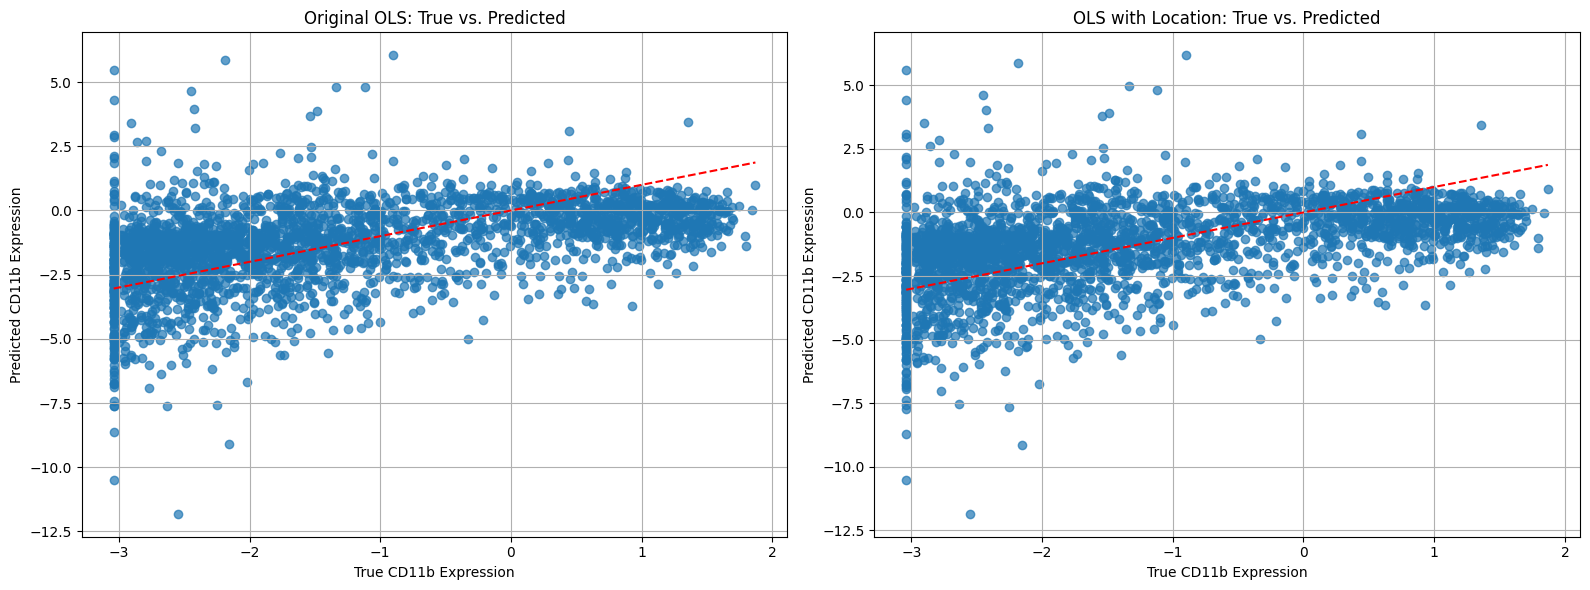


Comparison of OLS Regression Models:
RMSE - Original: 1.5821 vs. With Location: 1.5889
Pearson Correlation - Original: 0.4522 vs. With Location: 0.4531
Spearman Correlation - Original: 0.5178 vs. With Location: 0.5200
R2 Score - Original: -0.2136 vs. With Location: -0.2240


In [115]:
# ----------------------------
# Original OLS Regression (without location data)
# ----------------------------
print("Original OLS Regression (without location features)")

# Use the original feature DataFrames (from Q2(i))
X_train_orig = df_features.drop(columns=['CD11b']).values
y_train_orig = df_features['CD11b'].values

X_test_orig = df_features_test.drop(columns=['CD11b']).values
y_test_orig = df_features_test['CD11b'].values

# Train OLS model
ols_model_orig = LinearRegression()
ols_model_orig.fit(X_train_orig, y_train_orig)

# Predict on test data
y_pred_orig = ols_model_orig.predict(X_test_orig)

# Compute performance metrics for original model
rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
pearson_corr_orig, _ = pearsonr(y_test_orig, y_pred_orig)
spearman_corr_orig, _ = spearmanr(y_test_orig, y_pred_orig)
r2_orig = r2_score(y_test_orig, y_pred_orig)

print("Original OLS Regression Performance:")
print(f"RMSE: {rmse_orig:.4f}")
print(f"Pearson Correlation: {pearson_corr_orig:.4f}")
print(f"Spearman Correlation: {spearman_corr_orig:.4f}")
print(f"R2 Score: {r2_orig:.4f}")

# ----------------------------
# OLS Regression with Location Data
# ----------------------------
print("\nOLS Regression with Location Features")

# Add location columns to the training and test feature DataFrames
df_features_with_loc = df_features.copy()
df_features_with_loc['Location_Center_X'] = df.loc[df_features_with_loc.index, 'Location_Center_X']
df_features_with_loc['Location_Center_Y'] = df.loc[df_features_with_loc.index, 'Location_Center_Y']

df_features_test_with_loc = df_features_test.copy()
df_features_test_with_loc['Location_Center_X'] = df.loc[df_features_test_with_loc.index, 'Location_Center_X']
df_features_test_with_loc['Location_Center_Y'] = df.loc[df_features_test_with_loc.index, 'Location_Center_Y']

# Split features (X) and target (y) for training and test data with location data
X_train_loc = df_features_with_loc.drop(columns=['CD11b']).values
y_train_loc = df_features_with_loc['CD11b'].values

X_test_loc = df_features_test_with_loc.drop(columns=['CD11b']).values
y_test_loc = df_features_test_with_loc['CD11b'].values

print("Training data shape with location features:", X_train_loc.shape)
print("Test data shape with location features:", X_test_loc.shape)

# Build and train the OLS regression model with location data
ols_model_loc = LinearRegression()
ols_model_loc.fit(X_train_loc, y_train_loc)

# Predict on test data
y_pred_loc = ols_model_loc.predict(X_test_loc)

# Compute performance metrics for location model
rmse_loc = np.sqrt(mean_squared_error(y_test_loc, y_pred_loc))
pearson_corr_loc, _ = pearsonr(y_test_loc, y_pred_loc)
spearman_corr_loc, _ = spearmanr(y_test_loc, y_pred_loc)
r2_loc = r2_score(y_test_loc, y_pred_loc)

print("OLS Regression with Location Features Performance:")
print(f"RMSE: {rmse_loc:.4f}")
print(f"Pearson Correlation: {pearson_corr_loc:.4f}")
print(f"Spearman Correlation: {spearman_corr_loc:.4f}")
print(f"R2 Score: {r2_loc:.4f}")

# ----------------------------
# Plotting the Graphs Side-by-Side
# ----------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left Plot: Original OLS (without location)
axes[0].scatter(y_test_orig, y_pred_orig, alpha=0.7)
axes[0].set_xlabel("True CD11b Expression")
axes[0].set_ylabel("Predicted CD11b Expression")
axes[0].set_title("Original OLS: True vs. Predicted")
axes[0].grid(True)
axes[0].plot([min(y_test_orig), max(y_test_orig)], [min(y_test_orig), max(y_test_orig)], 'r--')

# Right Plot: OLS with Location Features
axes[1].scatter(y_test_loc, y_pred_loc, alpha=0.7)
axes[1].set_xlabel("True CD11b Expression")
axes[1].set_ylabel("Predicted CD11b Expression")
axes[1].set_title("OLS with Location: True vs. Predicted")
axes[1].grid(True)
axes[1].plot([min(y_test_loc), max(y_test_loc)], [min(y_test_loc), max(y_test_loc)], 'r--')

plt.tight_layout()
plt.show()

# ----------------------------
# Comparison of Metrics
# ----------------------------
print("\nComparison of OLS Regression Models:")
print(f"RMSE - Original: {rmse_orig:.4f} vs. With Location: {rmse_loc:.4f}")
print(f"Pearson Correlation - Original: {pearson_corr_orig:.4f} vs. With Location: {pearson_corr_loc:.4f}")
print(f"Spearman Correlation - Original: {spearman_corr_orig:.4f} vs. With Location: {spearman_corr_loc:.4f}")
print(f"R2 Score - Original: {r2_orig:.4f} vs. With Location: {r2_loc:.4f}")

Training Random Forest Regression Model with Randomized Grid Search on OLD features...
Old Features - RF Grid Search Training Time: 268.77 seconds
Best Parameters for old features:
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10}

Training Random Forest Regression Model with Randomized Grid Search on NEW features (with location)...
New Features - RF Grid Search Training Time: 308.11 seconds
Best Parameters for new features:
{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}

Comparison of Metrics:
Old Features:
  RMSE: 1.2949, Pearson: 0.5483, Spearman: 0.5547, R2: 0.1870
New Features (with location):
  RMSE: 1.3268, Pearson: 0.5232, Spearman: 0.5307, R2: 0.1465


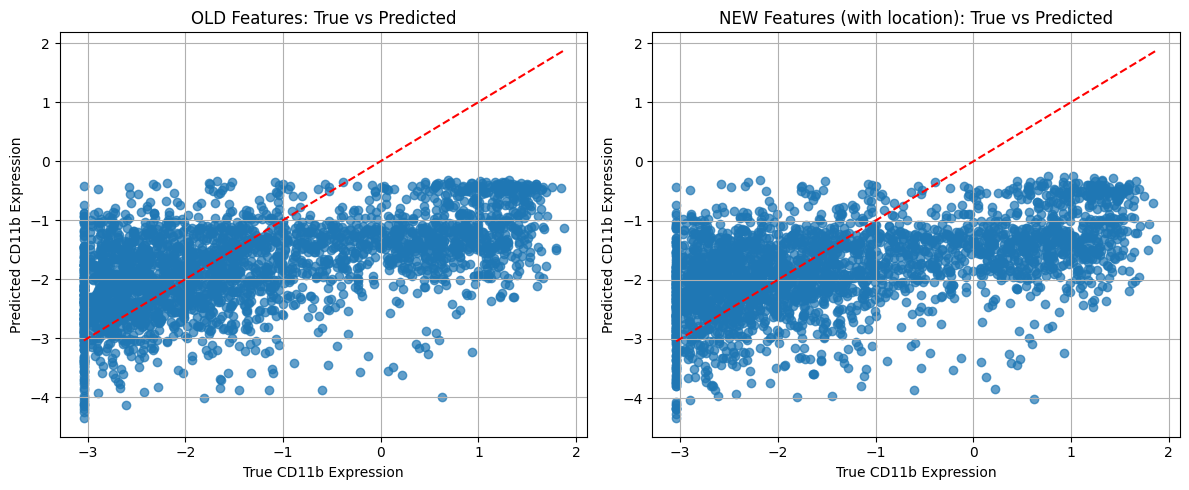

In [68]:
# Read the CSV file and create specimen/image IDs
df_rf = pd.read_csv('https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/protein_expression_data.csv')
df_rf['specimen_id'] = df_rf.VisSpot.apply(lambda x: x.split('-')[2])
df_rf['image_id'] = df_rf['specimen_id'] + '_' + df_rf['id'].astype(str)
df_rf = df_rf.set_index('image_id').sort_index()

# Define the image folder path (adjust as needed)
image_folder_rf = r"C:\Users\abdul\Documents\CS909 Data mining\assignment 2\patches_256"
image_files_rf = glob.glob(os.path.join(image_folder_rf, "*.png"))

# Initialize lists for training (specimens != A1) and test (specimen == A1)
train_basic = []  # basic features (12)
train_flat  = []  # flattened image for PCA (from resized 32x32 image)
train_loc   = []  # location features [Location_Center_X, Location_Center_Y]
train_target = [] # target: CD11b expression

test_basic = []
test_flat  = []
test_loc   = []
test_target = []

for img_path in image_files_rf:
    img_file = os.path.basename(img_path)
    img_id = os.path.splitext(img_file)[0]
    
    # Skip images not in CSV
    if img_id not in df_rf.index:
        continue
        
    specimen = df_rf.loc[img_id, 'specimen_id']
    
    # Read image and convert RGBA to RGB if needed
    I = imread(img_path)
    if I.ndim == 3 and I.shape[-1] == 4:
        I = rgba2rgb(I)
    
    # --- Extract Basic Features ---
    # From RGB channels
    R = I[:, :, 0]; G = I[:, :, 1]; B = I[:, :, 2]
    R_mean, R_var = np.mean(R), np.var(R)
    G_mean, G_var = np.mean(G), np.var(G)
    B_mean, B_var = np.mean(B), np.var(B)
    # From HED channels (using rgb2hed)
    I_hed = rgb2hed(I)
    H = I_hed[:, :, 0]; E = I_hed[:, :, 1]; D = I_hed[:, :, 2]
    H_mean, H_var = np.mean(H), np.var(H)
    E_mean, E_var = np.mean(E), np.var(E)
    D_mean, D_var = np.mean(D), np.var(D)
    
    basic_feats = [R_mean, R_var, G_mean, G_var, B_mean, B_var,
                   H_mean, H_var, E_mean, E_var, D_mean, D_var]
    
    # --- Prepare PCA Input: Resize image to 32x32 and flatten ---
    I_resized = resize(I, (32, 32), anti_aliasing=True)
    flat_img = I_resized.flatten()
    
    # --- Location Features from CSV ---
    loc_x = df_rf.loc[img_id, 'Location_Center_X']
    loc_y = df_rf.loc[img_id, 'Location_Center_Y']
    loc_feats = [loc_x, loc_y]
    
    # --- Target: CD11b Expression ---
    target = df_rf.loc[img_id, 'CD11b']
    
    # Split into training and test sets
    if specimen == 'A1':
        test_basic.append(basic_feats)
        test_flat.append(flat_img)
        test_loc.append(loc_feats)
        test_target.append(target)
    else:
        train_basic.append(basic_feats)
        train_flat.append(flat_img)
        train_loc.append(loc_feats)
        train_target.append(target)

# Convert lists to NumPy arrays
train_basic = np.array(train_basic)   # (n_train, 12)
train_flat  = np.array(train_flat)      # (n_train, 32*32*3)
train_loc   = np.array(train_loc)       # (n_train, 2)
train_target = np.array(train_target)    # (n_train,)

test_basic = np.array(test_basic)       # (n_test, 12)
test_flat  = np.array(test_flat)         # (n_test, 32*32*3)
test_loc   = np.array(test_loc)          # (n_test, 2)
test_target = np.array(test_target)      # (n_test,)

# --- Apply PCA on the training set flat images ---
n_components_rf = 7
pca_model_rf = PCA(n_components=n_components_rf, svd_solver='randomized', random_state=42)
pca_train = pca_model_rf.fit_transform(train_flat)  # (n_train, 10)
pca_test = pca_model_rf.transform(test_flat)         # (n_test, 10)

# --- Construct Feature Sets ---
# Old Features: Basic (12) + PCA (7) = 19 features
X_train_old = np.hstack([train_basic, pca_train])
X_test_old = np.hstack([test_basic, pca_test])

# New Features: Old features (19) + Location (2) = 21 features
X_train_new = np.hstack([X_train_old, train_loc])
X_test_new = np.hstack([X_test_old, test_loc])

y_train = train_target
y_test = test_target

# --- Randomized Grid Search Setup ---
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [None, 10, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8]
}

rf = RandomForestRegressor(random_state=21)

# --- Grid Search for Old Features ---
print("Training Random Forest Regression Model with Randomized Grid Search on OLD features...")
start_time = time.time()
rf_random_search_old = RandomizedSearchCV(estimator=rf,
                                          param_distributions=param_dist,
                                          n_iter=25,
                                          cv=4,
                                          random_state=21,
                                          n_jobs=-1,
                                          scoring='neg_mean_squared_error')
rf_random_search_old.fit(X_train_old, y_train)
old_train_time = time.time() - start_time
print(f"Old Features - RF Grid Search Training Time: {old_train_time:.2f} seconds")
print("Best Parameters for old features:")
print(rf_random_search_old.best_params_)

# --- Grid Search for New Features (with location) ---
print("\nTraining Random Forest Regression Model with Randomized Grid Search on NEW features (with location)...")
start_time = time.time()
rf_random_search_new = RandomizedSearchCV(estimator=rf,
                                          param_distributions=param_dist,
                                          n_iter=25,
                                          cv=4,
                                          random_state=21,
                                          n_jobs=-1,
                                          scoring='neg_mean_squared_error')
rf_random_search_new.fit(X_train_new, y_train)
new_train_time = time.time() - start_time
print(f"New Features - RF Grid Search Training Time: {new_train_time:.2f} seconds")
print("Best Parameters for new features:")
print(rf_random_search_new.best_params_)

# --- Evaluate Models on Test Data ---
# Old features predictions
y_pred_old = rf_random_search_old.best_estimator_.predict(X_test_old)
rmse_old = np.sqrt(mean_squared_error(y_test, y_pred_old))
pearson_old, _ = pearsonr(y_test, y_pred_old)
spearman_old, _ = spearmanr(y_test, y_pred_old)
r2_old = r2_score(y_test, y_pred_old)

# New features predictions
y_pred_new = rf_random_search_new.best_estimator_.predict(X_test_new)
rmse_new = np.sqrt(mean_squared_error(y_test, y_pred_new))
pearson_new, _ = pearsonr(y_test, y_pred_new)
spearman_new, _ = spearmanr(y_test, y_pred_new)
r2_new = r2_score(y_test, y_pred_new)

print("\nComparison of Metrics:")
print("Old Features:")
print(f"  RMSE: {rmse_old:.4f}, Pearson: {pearson_old:.4f}, Spearman: {spearman_old:.4f}, R2: {r2_old:.4f}")
print("New Features (with location):")
print(f"  RMSE: {rmse_new:.4f}, Pearson: {pearson_new:.4f}, Spearman: {spearman_new:.4f}, R2: {r2_new:.4f}")

# --- Plot Scatter Plots for Comparison ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_old, alpha=0.7)
plt.xlabel("True CD11b Expression")
plt.ylabel("Predicted CD11b Expression")
plt.title("OLD Features: True vs Predicted")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_new, alpha=0.7)
plt.xlabel("True CD11b Expression")
plt.ylabel("Predicted CD11b Expression")
plt.title("NEW Features (with location): True vs Predicted")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.grid(True)

plt.tight_layout()
plt.show()

## B. How can you determine whether your predictor is truly predicting CD11b expression independently, rather than just reflecting the combined influence of multiple correlated proteins? What are the potential implications if your predictor is not independent, and how can you address this limitation to improve the reliability of your findings? [5]

- **Assessing Independence:**  
  Evaluate the predictor using partial correlation or hierarchical regression to isolate the unique contribution of CD11b after accounting for the effects of correlated proteins.

- **Implications of Non-independence:**  
  If the predictor is influenced by multiple correlated proteins, it may not truly reflect CD11b expression. This can lead to misleading conclusions, overfitting, and poor generalizability across different biological conditions.

- **Addressing the Limitation:**  
  Utilize variable selection methods (e.g., LASSO) or dimensionality reduction techniques (e.g., PCA) to reduce multicollinearity. Alternatively, conduct ablation studies to determine the independent predictive power of CD11b-specific features.


In [71]:
# Define the target and the list of other proteins (excluding CD11b)
target_protein = 'CD11b'
other_proteins = [prot for prot in protein_names if prot != target_protein]

# Extract the actual CD11b expression for the test set and the expression values of the other proteins
Y_actual = df.loc[df_features_test.index, target_protein]
X_others_test = df.loc[df_features_test.index, other_proteins]

# Add a constant for regression
X_others_test_const = sm.add_constant(X_others_test)

# Regress actual CD11b on the other proteins to obtain residuals
model_actual = sm.OLS(Y_actual, X_others_test_const).fit()
resid_actual = model_actual.resid

# Regress predicted CD11b (from your model) on the other proteins to obtain residuals
model_pred = sm.OLS(y_pred_ols, X_others_test_const).fit()
resid_pred = model_pred.resid

# Compute the partial correlation between actual and predicted CD11b (i.e., correlation between residuals)
partial_corr, p_val = pearsonr(resid_actual, resid_pred)
print("Partial correlation (controlling for other proteins):", partial_corr)
print("P-value:", p_val)


Partial correlation (controlling for other proteins): 0.03514301774988318
P-value: 0.05871547285672128
